In [1]:
import sys
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay
import seaborn as sb
import warnings
import numpy as np
import matplotlib.pyplot as plt
from src.utils.metrics import separation_capacity, separation_capacity_tree
warnings.simplefilter(action="ignore")
import plotly.express as px

In [35]:
def comment_motion_detector(comment: str):
    keywords = ["motion", "moion", "motio", "ringing", "rinin", "ringin"]
    tocmp = comment.lower()
    return any(map(lambda x: x in tocmp, keywords))

In [77]:
ampscz_ssim_path="/home/chbricout/Downloads/AMPSCZ-conv5_fc3-ssim.csv"
ampscz_motion_path="/home/chbricout/Downloads/AMPSCZ-seres-motion.csv"
original_scores_path = "/home/chbricout/Master/mrart/src/dataset/ampscz/finetune.csv"

In [108]:
motion_df = pd.read_csv(ampscz_motion_path, index_col=0)
ssim_df = pd.read_csv(ampscz_ssim_path, index_col=0)
original_scores = pd.read_csv(original_scores_path, index_col=0)
original_scores['identifier']=original_scores['sub_id_gs']+'_'+original_scores['ses_id_gs'].astype(str)
# original_scores=original_scores.dropna(axis="index",subset=['comment'])
original_scores["motion"] = original_scores["comment"].fillna("").apply(
    comment_motion_detector
) & (original_scores['score'] <= 3)
score_df =original_scores[['identifier', 'score', 'group', 'motion', 'comment']]
original_scores[original_scores['motion']==True]
original_scores

,sub_id_gs,ses_id_gs,timepoint_gs,score,comment,sub-ses,site,motion,group,data,identifier
215,IR00124,202210141,baseline_arm_1,3,"moderate motion at bottom of brain, ringing fr...",IR00124-202210141,IR,True,train,AMPSCZ-Preproc/subjects/sub-IR00124/ses-202210...,IR00124_202210141
216,IR00124,202212211,month_2_arm_1,3,ringing throughout (especially axial view),IR00124-202212211,IR,True,train,AMPSCZ-Preproc/subjects/sub-IR00124/ses-202212...,IR00124_202212211
217,IR00491,202210171,baseline_arm_1,4,very faint ringing in nonnorm,IR00491-202210171,IR,False,train,AMPSCZ-Preproc/subjects/sub-IR00491/ses-202210...,IR00491_202210171
218,IR00491,202212191,month_2_arm_1,4,NaN,IR00491-202212191,IR,False,train,AMPSCZ-Preproc/subjects/sub-IR00491/ses-202212...,IR00491_202212191
219,IR01451,202210281,baseline_arm_1,3,some ringing in frontal lobe but not significant,IR01451-202210281,IR,True,train,AMPSCZ-Preproc/subjects/sub-IR01451/ses-202210...,IR01451_202210281
...,...,...,...,...,...,...,...,...,...,...,...
1090,YA08362,202210131,baseline_arm_1,3,"ringing, skull slightly misshapen",YA08362-202210131,YA,True,test,AMPSCZ-Preproc/subjects/sub-YA08362/ses-202210...,YA08362_202210131
1092,YA11278,202301261,baseline_arm_1,4,NaN,YA11278-202301261,YA,False,test,AMPSCZ-Preproc/subjects/sub-YA11278/ses-202301...,YA11278_202301261
1093,YA11278,202303301,month_2_arm_1,4,NaN,YA11278-202303301,YA,False,test,AMPSCZ-Preproc/subjects/sub-YA11278/ses-202303...,YA11278_202303301
1105,YA17816,202305041,baseline_arm_1,3,moderate ringing,YA17816-202305041,YA,True,test,AMPSCZ-Preproc/subjects/sub-YA17816/ses-202305...,YA17816_202305041


## For SSIM

In [109]:
ssim_pred = pd.merge(ssim_df, score_df, on="identifier")
ssim_pred['label']=ssim_pred['motion']
px.strip(ssim_pred, color="motion", x='pred', hover_name="identifier", hover_data="comment")

(np.float64(0.5324675324675324),
 <Figure size 600x500 with 1 Axes>,
 [np.float64(-0.0015902103041298687)])

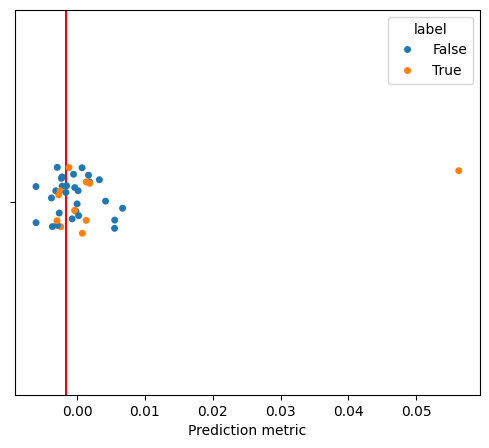

In [110]:
separation_capacity(ssim_pred)

(-0.01, 0.02)

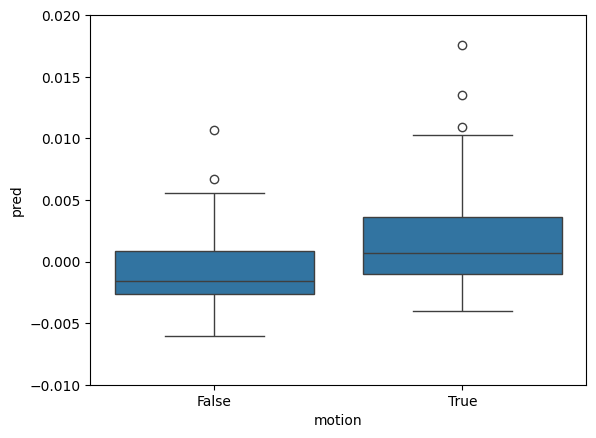

In [111]:
sb.boxplot(ssim_pred, y='p              red', x='motion')
plt.ylim((-0.01,0.02))

## For MOTION

In [69]:
motion_pred = pd.merge(motion_df, score_df, on="identifier")
motion_pred['label']=motion_pred['score'].astype(str)
px.strip(motion_pred, color="motion", x='pred', hover_name="identifier", hover_data=["score","comment"])

In [76]:
std = motion_pred['pred'].std()
conf_inf = motion_pred['pred'].mean()-1*std
conf_sup = motion_pred['pred'].mean()+1*std
conf_inf, conf_sup          
motion_pred['out_of_conf'] = motion_pred["pred"]>= conf_sup
px.strip(motion_pred, color="out_of_conf", x='pred', hover_name="identifier", hover_data=["score","comment"])